# Pretraining on unlabeled data

Now that we have defined the GPT model, we can implement a training function which will pre-train the model on unlabeled data.

In this notebook we will:

- Compute training and validation set losses
- Implement the training function
- Pre-Train the model
- Save and load the model weights to continue training
- Load the original pre-trained weights from OpenAI

In [1]:
import os
import sys
import torch

sys.path.append(os.path.dirname(os.path.abspath(".")))
from Chapter4.gpt_model import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,  # shorter than the original 1024
    "emb_dim": 768,
    "n_layers": 12,
    "n_heads": 12,
    "drop_rate": 0.1,  # often set to 0.0
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_

Next, we will define helper functions to convert text to tokens and vice versa.

In [2]:
import tiktoken
from Chapter4.generate_text_simple import generate_text_simple

def text_to_token_ids(text: str, tokenizer: tiktoken.Encoding) -> torch.Tensor:
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    # Add the batch dimension as the first dimension
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids: torch.Tensor, tokenizer: tiktoken.Encoding) -> str:
    # Remove the batch dimension here
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [3]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=256,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


Given we haven't yet trained the model, it doesn't do a great job of generating text. In order to see better outcomes, we start by defining the loss metric first.

### Calculating the text generation loss

In order to compute the loss of generated text for a given input, we need to go through the following steps we defined in previous chapters:

1. Use vocabulary to map the input to token IDs
2. Compute the probability row vector for each input token using the softmax function
3. Find the index with the highest probability via argmax
4. Get all predicted token IDs given by the index positions with the hightest probabilities
5. Map the index back to text using the inverse vocabulary

In the following we will go through an example with 2 input sequences.

In [4]:
# The input token IDs
inputs = torch.tensor([
    [16833, 3626, 6100],  # "Every effort moves", 
    [40, 1107, 588]  # "I really like"
])

# The target token IDs
targets = torch.tensor([
    [3626, 6100, 345],  # " effort moves you"
    [1107, 588, 11311]  # " really like chocolate"
])

# Feed input token IDs through the model
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape, "# [batch_size, context_length, vocab_size]")

torch.Size([2, 3, 50257]) # [batch_size, context_length, vocab_size]


The code above covers the first two steps in the list. We now need to continue with steps 3-5.

In [5]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Predictions batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

print(f"Targets batch 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"Predictions batch 2: {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Predictions batch 1:  Armed heNetflix
Targets batch 2:  really like chocolate
Predictions batch 2:  pressuring empoweredfaith


During training the aim is to increase the probability of the correct target tokens. The untrained model should have random target probabilities which, given the vocabulary size of 50257, should be around $1 / 50257 = 0.00002$

We can verify this by printing the probabilities of target tokens.

In [6]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(f"Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print(f"Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In order to compute the loss, we need to compute the cross-entropy loss for each input sequence. To do this we will need the logarithm of the probabilities. We then take the mean of those log probabilities and finally multiply them by -1. This is done as we want to *minimize* the loss function. Given the logarithm is increasing, we need to take the negative log to obtain a decreasing function for the loss.

In [7]:
# take the logarithm of the probabilities
log_probas = torch.log(probas)
print(log_probas)

# compute the cross-entropy loss
loss = -torch.mean(log_probas)
print(f"Loss: {loss.item()}")

print("Logits shape: ", logits.shape)
print("Targets shape: ", targets.shape)


tensor([[[-10.8790, -11.0961, -11.3570,  ..., -10.7061, -11.8728, -10.8829],
         [-11.6010, -11.5068, -11.7514,  ..., -10.4451, -12.0220, -11.2076],
         [-10.4184, -11.6350, -11.0592,  ..., -10.2472, -11.1697, -11.2109]],

        [[-11.2849, -10.7933, -11.1530,  ..., -11.4748, -10.2664, -11.1595],
         [-11.8313, -10.9327, -11.4580,  ..., -10.7612, -11.3828, -11.0709],
         [-10.4312, -10.3008, -10.1012,  ..., -11.9399,  -9.7516, -11.1983]]])
Loss: 10.991869926452637
Logits shape:  torch.Size([2, 3, 50257])
Targets shape:  torch.Size([2, 3])


For the loss function we want to flatten the dimensions of the logits and targets over the batch size. We can do this using the `flatten()` function.

In [8]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened Logits shape: ", logits_flat.shape)
print("Flattened Targets shape: ", targets_flat.shape)

Flattened Logits shape:  torch.Size([6, 50257])
Flattened Targets shape:  torch.Size([6])


We applied the softmax, select the largets probability score and compute the negative log probabilities. In practice, we can use the PyTorch function `cross_entropy` to do this:

In [9]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(f"Loss: {loss.item()}")

Loss: 10.793964385986328


In order to evaluate a trained language model, we can look at the *perplexity* of the model. It measures how well the predicted probability distribution matches the distribution of the actual words in the dataset. A lower perplexity is better.

It can be computed using $perplexity = torch.exp(loss)$. In our example, this would return $tensor(48725.8203)$ which can be interpreted as the model being unsure which of 48,725 tokens of our vocabulary it should use to generate the next token.

### Calculating the training and validation set losses

Next we will prepare our training and validation datasets and compute the loss for them.

We will again use "The Verdict" as our dataset.

In [10]:
file_path = "../Chapter2/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text = f.read()

total_characters = len(text)
total_tokens = len(tokenizer.encode(text))

print(f"Total characters: {total_characters}")
print(f"Total tokens: {total_tokens}")

Total characters: 20479
Total tokens: 5145


Next, we will split this dataset into training and validation sets and prepare the batches.

In [11]:
train_ratio = 0.9
split_idx = int(train_ratio * total_characters)

train_data = text[:split_idx]
val_data = text[split_idx:]

print(f"Train data length: {len(train_data)}")
print(f"Validation data length: {len(val_data)}")

Train data length: 18431
Validation data length: 2048


In [12]:
from Chapter2.data_utils import created_dataloader_v1

torch.manual_seed(123)

train_loader = created_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = created_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

# Iterate over the training and validation batches
print("Train loader:")
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)

print("Validation loader:")
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

Train loader:
0 torch.Size([2, 256]) torch.Size([2, 256])
1 torch.Size([2, 256]) torch.Size([2, 256])
2 torch.Size([2, 256]) torch.Size([2, 256])
3 torch.Size([2, 256]) torch.Size([2, 256])
4 torch.Size([2, 256]) torch.Size([2, 256])
5 torch.Size([2, 256]) torch.Size([2, 256])
6 torch.Size([2, 256]) torch.Size([2, 256])
7 torch.Size([2, 256]) torch.Size([2, 256])
8 torch.Size([2, 256]) torch.Size([2, 256])
Validation loader:
0 torch.Size([2, 256]) torch.Size([2, 256])


Given our small dataset, we only have 9 training batches with 2 samples each and a single validation batch.

Next we implement a helper function to compute the loss.

In [13]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten())
    return loss        

Let's add another utility function to compute the loss across all batches.

In [14]:
def calc_loss_loader(data_loader, model, device, *, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()
    return total_loss / num_batches

We can now use it to compute the training and validation loss of our datasets.

In [15]:
device_str = "cuda" if torch.cuda.is_available() else "cpu"
# For Apple Silicon
# if torch.backends.mps.is_available():
#     device_str = "mps"
device = torch.device(device_str)

model.to(device)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print(f"Train loss: {train_loss}")
print(f"Validation loss: {val_loss}")

Train loss: 10.987583690219456
Validation loss: 10.98110580444336


## Training the LLM

Now that we defined the loss function and a utility function to compute it, we can implement a first version of the training routine, a function to evaluate the model and a generate and print utility function.

In [16]:
def train_model_simple(model, train_loader, val_loader, optimizer, 
                       device, num_epochs, eval_freq, eval_iter, 
                       start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            global_step += 1
            tokens_seen += input_batch.numel()

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss: {train_loss:.3f}, "
                    f"Val loss: {val_loss:.3f}"
                )
                
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()
        

We can now train our first GPTModel for 10 epochs using the AdamW optimizer and above functions.

In [17]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-1)
num_epochs = 10
train_losses, val_losses, track_tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device, 
    num_epochs=num_epochs, eval_freq=5, eval_iter=5, 
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss: 10.506, Val loss: 10.576
Ep 1 (Step 000005): Train loss: 9.230, Val loss: 9.416
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010): Train loss: 8.648, Val loss: 8.886
Ep 2 (Step 000015): Train loss: 8.073, Val loss: 8.426
Every effort moves you, the,, the,, the,,,, the, the,,,, the,,,,,,,,, the,, the,,,, the,,, the,,,,,,,,
Ep 3 (Step 000020): Train loss: 7.611, Val loss: 7.969
Ep 3 (Step 000025): Train loss: 7.170, Val loss: 7.580
Every effort moves you, the, the the the the the the the the the the the.                                   
Ep 4 (Step 000030): Train loss: 6.644, Val loss: 7.247
Ep 4 (Step 000035): Train loss: 6.247, Val loss: 6.976
Every effort moves you, and, and the the of the.       ", I had the, the, I had the ".            ", and, and I had the
Ep 5 (Step 000040): Train loss: 5.874, Val loss: 6.810
Every effort moves you, and, and the of the of the of the of the of the of the, and I had the the,

The training loss has continued to improve over the full 10 epochs but the validation loss begun to saturate. Let's first plot the loss curves.

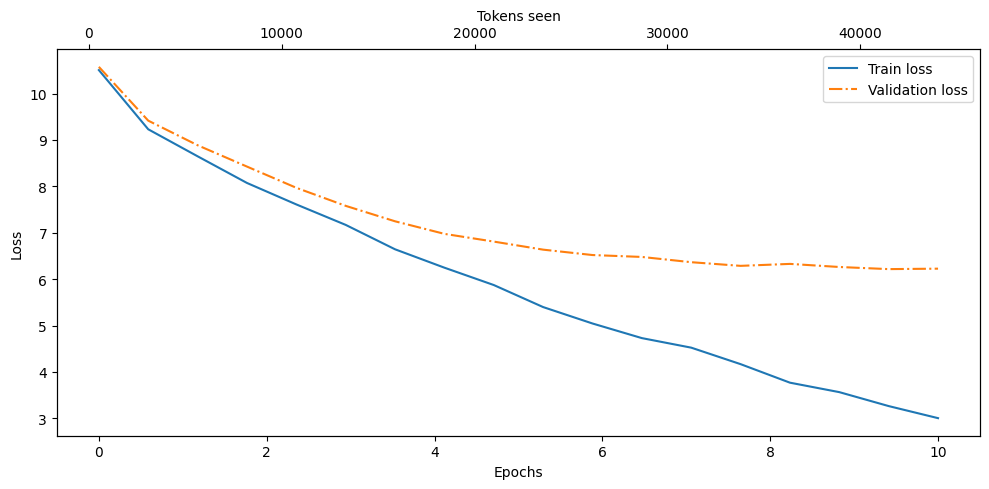

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(epochs_seen, train_losses, label="Train loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Creates invisible line to align axis
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)

While both training and validation loss decrease over the first few epochs, they start diverging around epoch 4. This is expected given the small dataset we are using to train and indicates that the model starts to memorize the training data. 

## Varying the decoding strategy

Our current decoder always picks the token with the hightest probability. In order to create some variation in the output we will add two concepts, *temperature_scaling* and *top-k-sampling* to our function.

First we print the predicted text of our current implementation.

In [19]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know it was not that, one of the to the fact with a little a.










 ### Temperature scaling

 Temperature scaling is a technique used to adjust the probabilities of the model's output. It introduces a temperature parameter that controls the randomness of the predictions.

 For illustration, we will use a very small vocabulary.

In [20]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

We then hard-code the logits for the next token predicton and convert them to probabilities using the softmax function.

In [21]:
next_token_logits = torch.tensor(
    [4.501, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])


forward


To implement a probabilistic sampling process, we replace the argmax function with a multinomial.

In [22]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


The result in this case is the same because the multinomial function samples the word according to the assinged probabilities. In our manually defined example, the probability for the word "forward" is significantly higher than that of any other word.
We can implement a function which tracks how often a word will be chosen if we draw 1000 samples.

In [23]:
def print_sampled_tokens(probas, num_samples=1000):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(num_samples)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

72 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
344 x toward


We can see that it will output "forward" in the vast majority of cases. The other possible options also seem to make sense in context of the input sequence "every effort moves you" - those are "toward", "closer" and "inches".

*Temperature scaling* controls the selection process by chaning the logits so they become more equal. This is achieved by simply dividing them. Let's define a function and use it to compute and plot the sampled frequencies.

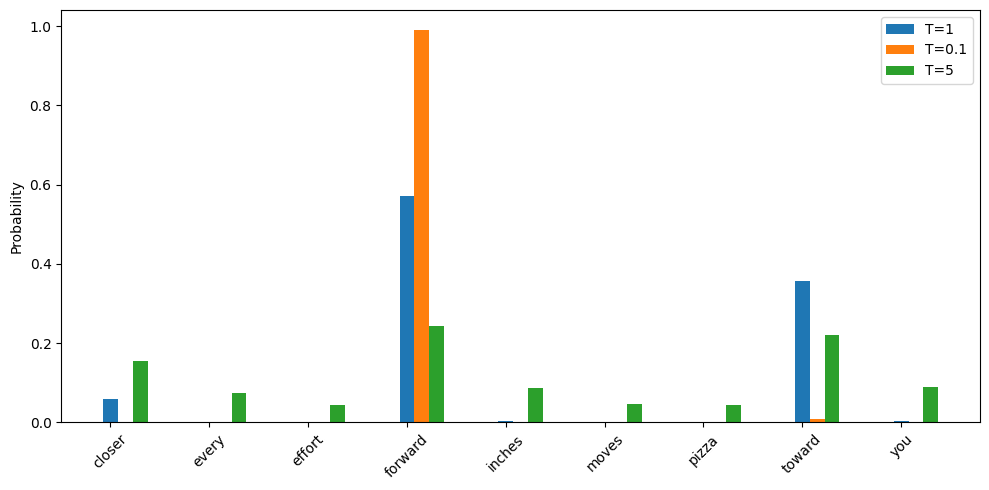

In [24]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)


temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, t) for t in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15

fix, ax = plt.subplots(figsize=(10, 5))
for i, t in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f"T={t}")
ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

We can see that temperatures > 1 smoothen out the distribution and other words become more frequent, while temperatures < 1 emphasize the most likely word even more and suppress other potential words.

## Top-k sampling

While the approach above gave us more diverse output sequences, it also meant that some of them make less sense grammatically. Top-k sampling, combined with probabilistic sampling and temperature scaling can improve this by only allowing samples from the k most likely tokens.

We can illustrate the implementation with an example.

In [25]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(-float("inf")),
    other=next_token_logits
)
print("New logits:", new_logits)
topk_probas = torch.softmax(top_logits, dim=0)
print("Top-k probabilities:", topk_probas)

Top logits: tensor([6.7500, 6.2800, 4.5010])
Top positions: tensor([3, 7, 0])
New logits: tensor([4.5010,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
Top-k probabilities: tensor([0.5779, 0.3612, 0.0610])


### Combine with text generation function

We now add the functionalities developed above to our text generation function.

In [26]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, top_pos = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                condition=logits < min_val,
                input=torch.tensor(-float("inf")),
                other=logits
            )
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=-1)

    return idx

In [27]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    temperature=1.4,
    top_k=25
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," she to. " was one of that, my by his



If we comment out the manual seed and generate outputs multiple times, we will see that the output varies significantly. How much it varies can be controlled by the new parameters `temperature` and `top_k`.

### Loading and saving weights

So far we have randomly initialised the weights and trained a model from scratch. In practice, training a full-scale LLM is very expensive and we usually start from pre-trained weights. 

In this section we will discuss how to save and load model weights.

The recommended way of saving a trained PyTorch model is shown below. It will create a file with the state_dict containing a dictionary of each layer with it's parameters.

In [28]:
torch.save(model.state_dict(), "model.pth")

We can subsequently load the saved weight again.

In [29]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_

Saving a model in this way is good if we want to do inference with it. If we are planning on continuing to train, starting from the saved state, we need to also save the state of the optimizer with it. Otherwise it will initialize without its parameters and training might not converge properly. This will then allow us to load the full state of the training process and continue fine-tuning.

In [30]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, "model_and_optimizer.pth")

checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_

### Loading pretrained weights from OpenAI

We will now load the weights from OpenAI's GPT-2 model. First, we have to download the weights for which we will use a script from the book.

In [31]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-From-Scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x390d92610>)

In [33]:
from Chapter5.gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(
    model_size="124M",
    models_dir="gpt2"
)

print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 25.0kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.27MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 32.5kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [03:04<00:00, 2.69MiB/s] 
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.74MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 819kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 787kiB/s] 


Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


We have downloaded the weights for the smallest GPT-2 model with 124M parameters. Other, larger, versions are available and can be downloaded in the same way. Let's create a dictionary with the different available GPT versions first and update the definition of the smallest model from earlier and initialize it.

In [34]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_heads": 12, "n_layers": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_heads": 16, "n_layers": 24},
    "gpt2-large (760M)": {"emb_dim": 1280, "n_heads": 20, "n_layers": 36},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_heads": 25, "n_layers": 48},
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_qu

To assign the pre-trained weights to our model, we first define a small function which checks that the initialized tensor and the weight have the same shape. If it doesn't, it will raise a ValueError.

In [47]:
import numpy as np

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch: {left.shape} != {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1
        )
        gpt.transformer_blocks[b].attention.W_query.weight = assign(
            gpt.transformer_blocks[b].attention.W_query.weight, q_w.T
        )
        gpt.transformer_blocks[b].attention.W_key.weight = assign(
            gpt.transformer_blocks[b].attention.W_key.weight, k_w.T
        )
        gpt.transformer_blocks[b].attention.W_value.weight = assign(
            gpt.transformer_blocks[b].attention.W_value.weight, v_w.T
        )

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1
        )
        gpt.transformer_blocks[b].attention.W_query.bias = assign(
            gpt.transformer_blocks[b].attention.W_query.bias, q_b
        )
        gpt.transformer_blocks[b].attention.W_key.bias = assign(
            gpt.transformer_blocks[b].attention.W_key.bias, k_b
        )
        gpt.transformer_blocks[b].attention.W_value.bias = assign(
            gpt.transformer_blocks[b].attention.W_value.bias, v_b
        )

        gpt.transformer_blocks[b].attention.out_proj.weight = assign(
            gpt.transformer_blocks[b].attention.out_proj.weight,
            (params["blocks"][b]["attn"]["c_proj"])["w"].T,
        )
        gpt.transformer_blocks[b].attention.out_proj.bias = assign(
            gpt.transformer_blocks[b].attention.out_proj.bias,
            (params["blocks"][b]["attn"]["c_proj"])["b"],
        )

        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight,
            (params["blocks"][b]["mlp"]["c_fc"])["w"].T,
        )
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias,
            (params["blocks"][b]["mlp"]["c_fc"])["b"],
        )
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight,
            (params["blocks"][b]["mlp"]["c_proj"])["w"].T,
        )
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias,
            (params["blocks"][b]["mlp"]["c_proj"])["b"],
        )

        gpt.transformer_blocks[b].ln1.scale = assign(
            gpt.transformer_blocks[b].ln1.scale,
            (params["blocks"][b]["ln_1"])["g"],
        )
        gpt.transformer_blocks[b].ln1.shift = assign(
            gpt.transformer_blocks[b].ln1.shift,
            (params["blocks"][b]["ln_1"])["b"]
        )
        gpt.transformer_blocks[b].ln2.scale = assign(
            gpt.transformer_blocks[b].ln2.scale,
            (params["blocks"][b]["ln_2"])["g"]
        )
        gpt.transformer_blocks[b].ln2.shift = assign(
            gpt.transformer_blocks[b].ln2.shift,
            (params["blocks"][b]["ln_2"])["b"]
        )

    gpt.final_norm.scale = assign(
        gpt.final_norm.scale, params["g"]
    )
    gpt.final_norm.shift = assign(
        gpt.final_norm.shift, params["b"]
    )
    # Out head reuses the weights from the token embedding layer
    gpt.out_head.weight = assign(
        gpt.out_head.weight, params["wte"]
    )

In [48]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (ln1): LayerNorm()
      (ln2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_qu

We can now use the model with pre-trained weights to generate text.

In [49]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


